## 範例
參考 `train.py` 實現的訓練模型程式碼範例


In [1]:
#%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

1.14.0


In [5]:
import glob
import os
import sys
import xml.etree.ElementTree as ET
import numpy as np
from kmeans import YOLO_Kmeans #kmeans, avg_iou


ROOT_PATH = '/VOCdevkit/VOC2007/'

CLUSTERS = 2

SIZE = 364


def load_dataset(path):
    jpegimages = os.path.join(path, 'JPEGImages')
    if not os.path.exists(jpegimages):
        print('no JPEGImages folders, program abort')
        sys.exit(0)
    labels_txt = os.path.join(path, 'Annotations')
    if not os.path.exists(labels_txt):
        print('no labels folders, program abort')
        sys.exit(0)

    label_file = os.listdir(labels_txt)
    print('label count: {}'.format(len(label_file)))
    dataset = []

    for label in label_file:
        with open(os.path.join(labels_txt, label), 'r') as f:
            txt_content = f.readlines()

        for line in txt_content:
            line_split = line.split(' ')
            roi_with = float(line_split[len(line_split)-2])
            roi_height = float(line_split[len(line_split)-1])
            if roi_with == 0 or roi_height == 0:
                continue
            dataset.append([roi_with, roi_height])
            # print([roi_with, roi_height])

    return np.array(dataset)

data = load_dataset(ROOT_PATH)
out = kmeans(data, k=CLUSTERS)

print(out)
print("Accuracy: {:.2f}%".format(avg_iou(data, out) * 100))
print("Boxes:\n {}-{}".format(out[:, 0] * SIZE, out[:, 1] * SIZE))

ratios = np.around(out[:, 0] / out[:, 1], decimals=2).tolist()
print("Ratios:\n {}".format(sorted(ratios)))

no JPEGImages folders, program abort


SystemExit: 0

c:\programdata\anaconda3\envs\tensorflow_gpu\lib\site-packages\IPython\core\interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
# 需要安裝 keras 2.2.4 的版本
pip install keras==2.2.4 

SyntaxError: invalid syntax (<ipython-input-2-78526c1d1f60>, line 2)

In [3]:
'''
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3
'''

"\nfrom google.colab import drive \ndrive.mount('/content/gdrive') # 將 google drive 掛載在 colob，\n# 下載基於 keras 的 yolov3 程式碼\n%cd 'gdrive/My Drive'\n# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉\n%cd keras-yolo3\n"

In [4]:
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


In [5]:
# 直接下載 VOC2007 的資料集作為範例
'''
if not os.path.exists("VOCdevkit"):
  os.system("wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar") # 下載 VOC 資料集
  os.system("tar xvf VOCtrainval_06-Nov-2007.tar") # 解壓縮資料集，會花幾分鐘
else:
  print("data exists")
'''  

'\nif not os.path.exists("VOCdevkit"):\n  os.system("wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar") # 下載 VOC 資料集\n  os.system("tar xvf VOCtrainval_06-Nov-2007.tar") # 解壓縮資料集，會花幾分鐘\nelse:\n  print("data exists")\n'

In [6]:
import os
dirpath = "VOCdevkit/VOC2007/JPEGImages/"
result = [f for f in os.listdir(dirpath) if os.path.isfile(os.path.join(dirpath,f))]
#print("\n目前檔案:\n",result)
with open("VOCdevkit/VOC2007/ImageSets/Main/2007_train.txt", "w") as f:
    for item in result:
        f.write("%s\n" % item.replace(".jpg",""))

以下的程式碼負責把下載下來的 Pascal VOC 資料集轉換為訓練模型時需要的格式，直接引用 https://github.com/qqwweee/keras-yolo3/blob/master/voc_annotation.py ，調整了一部分程式碼，讓我們只 sample 前 100 張圖片來做示範，在 colab 中會花一些時間跑完

In [7]:
if os.path.exists("/VOCdevkit/VOC2007/ImageSets/Main/2007_train.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
  import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
  from os import getcwd

  sets=[('2007', 'train'), ('2007', 'val')]
  #sets=[('2020', 'train'), ('2020', 'val')]

  # Pascal VOC 的資料類別
  #classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
  classes = ["kangaroo", "raccoon"]  

  # 把 annotation 轉換訓練時需要的資料形態
  def convert_annotation(year, image_id, list_file):
      in_file = open('/VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
      tree=ET.parse(in_file)
      root = tree.getroot()

      for obj in root.iter('object'):
          difficult = obj.find('difficult').text
          cls = obj.find('name').text
          if cls not in classes or int(difficult)==1:
              continue
          cls_id = classes.index(cls)
          xmlbox = obj.find('bndbox')
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
          list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

  wd = ".."

  for year, image_set in sets:
      image_ids = open('/VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
      #image_ids = open('D:/Company/python/keras-yolo3/final/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
      annotation_path = '%s_%s.txt'%(year, image_set)
      list_file = open(annotation_path, 'w')
      print("save annotation at %s" % annotation_path)
      for image_id in image_ids[:]: # 只處理 100 張圖片來做範例 [:100]
          #list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
          list_file.write('/VOCdevkit/VOC%s/JPEGImages/%s.jpg'%( year, image_id))
          #list_file.write('%s/finial/VOC%s/images/%s.jpg'%(wd, year, image_id))
          convert_annotation(year, image_id, list_file)
          list_file.write('\n')
      list_file.close()

In [8]:
# 將 train.py 所需要的套件載入
'''
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
'''

'\nimport numpy as np\nimport keras.backend as K\nfrom keras.layers import Input, Lambda\nfrom keras.models import Model\nfrom keras.optimizers import Adam\nfrom keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping\n\nfrom yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss\nfrom yolo3.utils import get_random_data\n'

In [9]:
# 將 train.py 所需要的套件載入
import numpy as np
from keras import backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


In [10]:
'''
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
# 載入 Callbacks
from tensorflow.python.keras.callbacks import ModelCheckpoint
import os.path
'''

'\nfrom tensorflow.python.keras import backend as K\nfrom tensorflow.python.keras.models import Model\nfrom tensorflow.python.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization\nfrom tensorflow.python.keras.applications.resnet50 import ResNet50\nfrom tensorflow.python.keras.optimizers import Adam\nfrom tensorflow.python.keras.preprocessing.image import ImageDataGenerator\n# 載入 Callbacks\nfrom tensorflow.python.keras.callbacks import ModelCheckpoint\nimport os.path\n'

In [11]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 `-w` 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [12]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [22]:
#from tensorflow.python.ops import control_flow_ops
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

annotation_path = '2007_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

#input_shape = (416,416) # multiple of 32, hw
input_shape = (416,416)

is_tiny_version = len(anchors)==6 # default setting

if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train

if True: # use custom yolo_loss Lambda layer.
    model.compile(optimizer=Adam(lr=1e-3), loss={'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 4
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0
            ,callbacks=[logging, checkpoint]
                       )
     # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    #train_acc = model.history.history["Accuracy"]
    #valid_acc = model.history.history["val_accuracy"]
    
   
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    #for i in range(len(model.layers)):
    #    model.layers[i].trainable = True
    model.compile( optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 4 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr] #, early_stopping
                       )
    
    train1_loss = model.history.history["loss"]
    valid1_loss = model.history.history["val_loss"]
    
    model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 2 classes.


c:\programdata\anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
c:\programdata\anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
c:\programdata\anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
c:\programdata\anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
c:\programdata\anaconda3\envs\tensorflow_gpu\lib\site-packages

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Train on 252 samples, val on 28 samples, with batch size 4.
Epoch 1/50
63/63 [==============================] - 25s 390ms/step - loss: 1891.8825 - val_loss: 218.2260
Epoch 2/50
63/63 [==============================] - 21s 326ms/step - loss: 156.4999 - val_loss: 107.4772
Epoch 3/50
63/63 [==============================] - 21s 327ms/step - loss: 94.7118 - val_loss: 73.3124
Epoch 4/50
63/63 [==============================] - 21s 327ms/step - loss: 69.0645 - val_loss: 54.2924
Epoch 5/50
63/63 [==============================] - 21s 327ms/step - loss: 55.9487 - val_loss: 47.5222
Epoch 6/50
63/63 [==============================] - 21s 328ms/step - loss: 46.3482 - val_loss: 40.4928
Epoch 7/50
63/63 [==============================] - 21s 329ms/step - loss: 40.4677 - val_loss: 36.9295
Epoch 8/50
63/63 [==============================] - 21s 328ms/step - loss: 36.4886 - val_loss: 31.9414
Epoch 9/50
63/63 [===

63/63 [==============================] - 21s 336ms/step - loss: 16.1257 - val_loss: 16.3024

Epoch 00073: ReduceLROnPlateau reducing learning rate to 9.999999717180686e-11.
Epoch 74/100
63/63 [==============================] - 21s 336ms/step - loss: 16.2377 - val_loss: 15.9024
Epoch 75/100
63/63 [==============================] - 21s 336ms/step - loss: 16.3946 - val_loss: 16.4976
Epoch 76/100
63/63 [==============================] - 21s 336ms/step - loss: 16.1630 - val_loss: 16.1897

Epoch 00076: ReduceLROnPlateau reducing learning rate to 9.99999943962493e-12.
Epoch 77/100
63/63 [==============================] - 21s 336ms/step - loss: 16.4243 - val_loss: 16.7788
Epoch 78/100
63/63 [==============================] - 21s 337ms/step - loss: 16.3315 - val_loss: 17.1543
Epoch 79/100
63/63 [==============================] - 21s 336ms/step - loss: 16.5496 - val_loss: 16.5104

Epoch 00079: ReduceLROnPlateau reducing learning rate to 9.999999092680235e-13.
Epoch 80/100
63/63 [================

In [23]:
#計算IOU
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    
    return iou

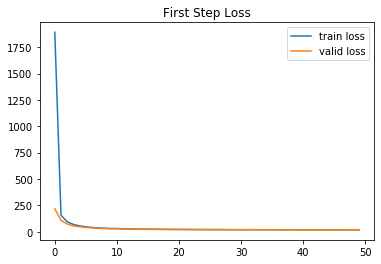

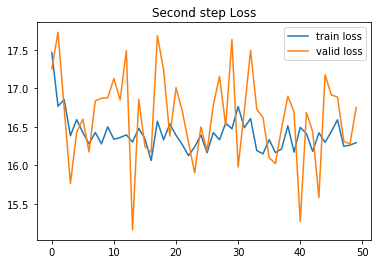

'\nplt.plot(range(len(train_acc)), train_acc, label="train accuracy")\nplt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")\nplt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors=\'r\', linestyles=\'--\')\nplt.legend()\nplt.title("Accuracy")\nplt.show()\n'

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

#loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
#plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("First Step Loss")
plt.show()

plt.plot(range(len(train1_loss)), train1_loss, label="train loss")
plt.plot(range(len(valid1_loss)), valid1_loss, label="valid loss")
#plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Second step Loss")
plt.show()
'''
plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()
'''

In [25]:
from PIL import Image
image = Image.open('D:/Company\python/keras-yolo3/VOCdevkit\VOC2007/JPEGImages/00016.jpg') #raccoon-41  00049 00017 00036

In [26]:
from yolo import YOLO

log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path) #trained_weights_final
r_image = yolo_model.detect_image(image)

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93  (155, 41) (422, 398)
1.1427101000008406


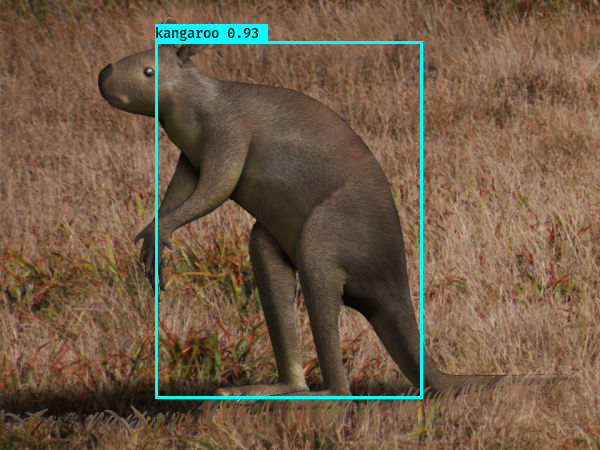

In [27]:
r_image

In [49]:
iou = bb_intersection_over_union( [91, 15, 565, 415], [128, 0, 473, 450])
print(iou)

0.6677704247382986


In [20]:
from yolo import YOLO
import  yolo
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'

yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path) #trained_weights_final
r_image = yolo.detect_video(yolo_model,"Kangaroo.mp4")

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 3 boxes for img
raccoon 0.66  (415, 25) (1206, 678)
kangaroo 0.59  (6, 0) (501, 720)
kangaroo 0.62  (149, 24) (1160, 667)
1.6163470999999845
(416, 416, 3)
Found 3 boxes for img
raccoon 0.66  (415, 25) (1206, 678)
kangaroo 0.53  (8, 0) (500, 720)
kangaroo 0.63  (153, 25) (1157, 667)
0.11435589999928197
(416, 416, 3)
Found 3 boxes for img
raccoon 0.74  (455, 28) (1160, 691)
kangaroo 0.38  (75, 78) (1230, 627)
kangaroo 0.72  (48, 0) (456, 720)
0.10904239999945275
(416, 416, 3)
Found 3 boxes for img
raccoon 0.70  (454, 4) (1164, 717)
kangaroo 0.34  (95, 70) (1205, 645)
kangaroo 0.72  (42, 0) (469, 710)
0.10956879999957891
(416, 416, 3)
Found 4 boxes for img
raccoon 0.46  (332, 0) (1280, 720)
kangaroo 0.30  (315, 0) (754, 720)
kangaroo 0.36  (219, 0) (1270, 720)
kangaroo 0.59  (19, 0) (471, 720)
0.11011359999974957
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42  (50, 0) (454, 685)
kangaroo 0.59  (29

Found 1 boxes for img
kangaroo 0.54  (251, 165) (595, 575)
0.10773860000062996
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.55  (247, 165) (600, 573)
0.11278870000023744
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56  (245, 162) (602, 575)
0.1061357999997199
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56  (240, 166) (610, 571)
0.10529599999972561
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.57  (241, 172) (609, 565)
0.10656469999958063
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.55  (246, 170) (604, 568)
0.1048175000005358
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54  (243, 182) (605, 556)
0.10735759999988659
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.52  (245, 181) (603, 559)
0.10532699999930628
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54  (252, 182) (597, 558)
0.10634769999978744
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54  (255, 180) (594, 560)
0.10488450000048033
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54  (250, 181) (598, 560)
0.10618619999

Found 1 boxes for img
kangaroo 0.59  (110, 28) (939, 688)
0.10573500000009517
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54  (74, 21) (974, 698)
0.10504570000011881
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54  (75, 20) (973, 699)
0.10467640000024403
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36  (101, 31) (938, 693)
0.10637270000006538
(416, 416, 3)
Found 0 boxes for img
0.10705630000029487
(416, 416, 3)
Found 0 boxes for img
0.10391610000078799
(416, 416, 3)
Found 0 boxes for img
0.10569820000000618
(416, 416, 3)
Found 0 boxes for img
0.1033039000003555
(416, 416, 3)
Found 0 boxes for img
0.1040856999998141
(416, 416, 3)
Found 0 boxes for img
0.10521210000024439
(416, 416, 3)
Found 0 boxes for img
0.10506979999991017
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37  (0, 63) (1120, 720)
0.1059079999995447
(416, 416, 3)
Found 0 boxes for img
0.1049289000002318
(416, 416, 3)
Found 0 boxes for img
0.10390730000017356
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33  (316, 

Found 1 boxes for img
kangaroo 0.55  (5, 0) (914, 720)
0.10562039999967965
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.55  (5, 0) (913, 720)
0.10788849999971717
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44  (56, 0) (872, 720)
0.10671770000044489
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56  (69, 0) (845, 720)
0.1061623999994481
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43  (92, 0) (849, 720)
0.10888539999996283
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54  (169, 0) (772, 720)
0.10602500000004511
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.53  (175, 0) (766, 720)
0.10620160000053147
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.53  (106, 0) (847, 720)
0.10774800000035611
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36  (140, 0) (902, 595)
kangaroo 0.68  (144, 0) (803, 720)
0.10752339999999094
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65  (116, 0) (915, 720)
0.10611900000003516
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42  (201, 0) (856, 720)
kangar

Found 0 boxes for img
0.10319799999979296
(416, 416, 3)
Found 0 boxes for img
0.10485849999986385
(416, 416, 3)
Found 0 boxes for img
0.10677720000057889
(416, 416, 3)
Found 0 boxes for img
0.10281409999970492
(416, 416, 3)
Found 0 boxes for img
0.10421349999978702
(416, 416, 3)
Found 0 boxes for img
0.1061176000002888
(416, 416, 3)
Found 0 boxes for img
0.10615779999989172
(416, 416, 3)
Found 0 boxes for img
0.10303139999996347
(416, 416, 3)
Found 0 boxes for img
0.1038062000006903
(416, 416, 3)
Found 0 boxes for img
0.10496640000019397
(416, 416, 3)
Found 0 boxes for img
0.10370830000010756
(416, 416, 3)
Found 0 boxes for img
0.10771380000005593
(416, 416, 3)
Found 0 boxes for img
0.10581770000044344
(416, 416, 3)
Found 0 boxes for img
0.10418329999993148
(416, 416, 3)
Found 0 boxes for img
0.10584499999913533
(416, 416, 3)
Found 0 boxes for img
0.10537999999996828
(416, 416, 3)
Found 0 boxes for img
0.10510270000031596
(416, 416, 3)
Found 0 boxes for img
0.10496089999924152
(416, 41

Found 1 boxes for img
kangaroo 0.35  (1, 107) (285, 412)
0.10691029999998136
(416, 416, 3)
Found 0 boxes for img
0.10313700000006065
(416, 416, 3)
Found 0 boxes for img
0.10438620000059018
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30  (0, 131) (310, 373)
0.10665270000026794
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.35  (0, 133) (288, 381)
0.11306339999919146
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34  (0, 133) (288, 381)
0.10537560000011581
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36  (0, 149) (282, 375)
0.10745610000049055
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30  (1062, 418) (1280, 720)
kangaroo 0.42  (0, 155) (293, 369)
0.10839409999971394
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32  (1063, 397) (1280, 720)
kangaroo 0.49  (0, 153) (294, 380)
0.10995699999966746
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32  (1066, 402) (1280, 720)
kangaroo 0.55  (0, 145) (304, 382)
0.10934480000014446
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32  (1066,

Found 1 boxes for img
kangaroo 0.82  (253, 254) (791, 677)
0.10429480000038893
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33  (400, 280) (714, 588)
0.10548800000015035
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41  (62, 286) (468, 679)
0.10519349999958649
(416, 416, 3)
Found 0 boxes for img
0.10565820000010717
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44  (20, 268) (684, 676)
0.10560799999984738
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.48  (18, 267) (685, 675)
0.1079117999997834
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71  (12, 258) (708, 672)
0.10790330000054382
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.52  (109, 320) (640, 632)
0.10544070000014472
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51  (94, 287) (672, 665)
0.10591810000005353
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38  (649, 322) (1150, 580)
kangaroo 0.64  (227, 308) (714, 646)
0.10726929999964341
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36  (647, 319) (1153, 583)
kangaroo 0.65  

Found 2 boxes for img
raccoon 0.33  (587, 0) (1083, 720)
kangaroo 0.52  (587, 0) (1083, 720)
0.10677949999990233
(416, 416, 3)
Found 2 boxes for img
raccoon 0.37  (568, 0) (1099, 720)
kangaroo 0.43  (568, 0) (1099, 720)
0.10859830000026705
(416, 416, 3)
Found 2 boxes for img
raccoon 0.38  (568, 0) (1098, 720)
kangaroo 0.43  (568, 0) (1098, 720)
0.10974439999972674
(416, 416, 3)
Found 2 boxes for img
raccoon 0.35  (589, 0) (1070, 720)
kangaroo 0.49  (589, 0) (1070, 720)
0.10644349999984115
(416, 416, 3)
Found 2 boxes for img
raccoon 0.44  (566, 23) (1100, 713)
kangaroo 0.35  (566, 23) (1100, 713)
0.10701619999963441
(416, 416, 3)
Found 1 boxes for img
raccoon 0.49  (569, 56) (1093, 686)
0.10573509999994712
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55  (548, 0) (1107, 720)
0.10705520000010438
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55  (547, 0) (1108, 720)
0.10447110000040993
(416, 416, 3)
Found 1 boxes for img
raccoon 0.58  (553, 39) (1107, 719)
0.10876699999971606
(416, 416, 

Found 1 boxes for img
raccoon 0.31  (66, 0) (1280, 720)
0.10576399999990826
(416, 416, 3)
Found 0 boxes for img
0.10697049999998853
(416, 416, 3)
Found 0 boxes for img
0.10334640000019135
(416, 416, 3)
Found 0 boxes for img
0.10336090000055265
(416, 416, 3)
Found 0 boxes for img
0.10364419999950769
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40  (594, 0) (1221, 720)
0.1068546000005881
(416, 416, 3)
Found 2 boxes for img
raccoon 0.34  (571, 145) (1253, 554)
raccoon 0.37  (625, 0) (1191, 720)
0.10528699999940727
(416, 416, 3)
Found 2 boxes for img
raccoon 0.34  (570, 145) (1254, 554)
raccoon 0.38  (624, 0) (1191, 720)
0.1078683000005185
(416, 416, 3)
Found 2 boxes for img
raccoon 0.32  (572, 0) (1244, 720)
raccoon 0.36  (600, 152) (1244, 554)
0.10832320000008622
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48  (597, 148) (1257, 543)
0.1037173000004259
(416, 416, 3)
Found 0 boxes for img
0.11021399999935966
(416, 416, 3)
Found 0 boxes for img
0.10345270000016171
(416, 416, 3)
Found 0 b

Found 2 boxes for img
raccoon 0.49  (0, 32) (1280, 620)
kangaroo 0.37  (353, 44) (1068, 502)
0.10691789999964385
(416, 416, 3)
Found 2 boxes for img
raccoon 0.73  (0, 0) (1280, 602)
kangaroo 0.55  (337, 14) (1087, 531)
0.10709720000068046
(416, 416, 3)
Found 2 boxes for img
raccoon 0.69  (0, 0) (1280, 552)
kangaroo 0.62  (327, 46) (1093, 500)
0.10830409999925905
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66  (20, 89) (1252, 490)
0.10688500000014756
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81  (0, 104) (1280, 479)
0.1110804999998436
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66  (0, 55) (1280, 529)
0.10550039999998262
(416, 416, 3)
Found 3 boxes for img
raccoon 0.57  (0, 47) (1280, 631)
kangaroo 0.32  (0, 68) (1280, 508)
kangaroo 0.32  (266, 0) (1159, 646)
0.10797249999995984
(416, 416, 3)
Found 3 boxes for img
raccoon 0.62  (0, 48) (1280, 629)
kangaroo 0.30  (0, 71) (1280, 507)
kangaroo 0.34  (260, 0) (1163, 650)
0.10971219999919413
(416, 416, 3)
Found 1 boxes for img
rac

Found 0 boxes for img
0.10521429999971588
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43  (309, 115) (1140, 646)
0.1042210999994495
(416, 416, 3)
Found 0 boxes for img
0.10427810000055615
(416, 416, 3)
Found 0 boxes for img
0.10480459999962477
(416, 416, 3)
Found 0 boxes for img
0.10648970000056579
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46  (729, 18) (1199, 628)
0.10758030000033614
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.67  (125, 11) (1183, 566)
0.10562490000029356
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63  (0, 36) (1280, 530)
0.10649939999984781
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40  (412, 7) (1057, 591)
kangaroo 0.71  (22, 81) (1263, 474)
0.10666679999940243
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41  (410, 5) (1057, 593)
kangaroo 0.71  (26, 80) (1257, 476)
0.10597409999991214
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65  (162, 80) (1131, 472)
0.10709740000038437
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78  (107, 92) (1187, 453

Found 1 boxes for img
kangaroo 0.74  (42, 124) (1051, 555)
0.10746289999951841
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64  (0, 50) (1125, 657)
0.10601430000042456
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.62  (0, 38) (1154, 670)
0.10609349999958795
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91  (0, 114) (1111, 584)
0.10749120000036783
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.35  (0, 0) (1239, 720)
0.10635679999995773
(416, 416, 3)
Found 0 boxes for img
0.10431139999946026
(416, 416, 3)
Found 0 boxes for img
0.10381330000018352
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30  (213, 132) (1069, 562)
0.10585289999926317
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56  (266, 26) (990, 686)
0.105697500000133
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.48  (235, 147) (1020, 551)
0.1062432999997327
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.46  (119, 101) (1136, 604)
kangaroo 0.49  (411, 190) (1036, 520)
0.10856809999950201
(416, 416, 3)
Found 0 boxes for img


Found 0 boxes for img
0.1056986000003235
(416, 416, 3)
Found 0 boxes for img
0.10561469999993278
(416, 416, 3)
Found 0 boxes for img
0.10437050000018644
(416, 416, 3)
Found 0 boxes for img
0.10587109999960376
(416, 416, 3)
Found 0 boxes for img
0.10496010000042588
(416, 416, 3)
Found 0 boxes for img
0.10497039999972912
(416, 416, 3)
Found 0 boxes for img
0.10385650000080204
(416, 416, 3)
Found 0 boxes for img
0.10599550000006275
(416, 416, 3)
Found 0 boxes for img
0.10526579999987007
(416, 416, 3)
Found 0 boxes for img
0.10449169999992591
(416, 416, 3)
Found 0 boxes for img
0.10417739999957121
(416, 416, 3)
Found 0 boxes for img
0.10912949999965349
(416, 416, 3)
Found 0 boxes for img
0.10844410000026983
(416, 416, 3)
Found 0 boxes for img
0.10513989999981277
(416, 416, 3)
Found 0 boxes for img
0.10677690000011353
(416, 416, 3)
Found 0 boxes for img
0.10485389999939798
(416, 416, 3)
Found 0 boxes for img
0.10510699999940698
(416, 416, 3)
Found 0 boxes for img
0.10330659999999625
(416, 4

Found 0 boxes for img
0.1040302999999767
(416, 416, 3)
Found 0 boxes for img
0.10476700000072015
(416, 416, 3)
Found 0 boxes for img
0.1050586999999723
(416, 416, 3)
Found 0 boxes for img
0.10715740000068763
(416, 416, 3)
Found 0 boxes for img
0.10707529999945109
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50  (683, 341) (830, 567)
0.10754509999969741
(416, 416, 3)
Found 0 boxes for img
0.10546359999989363
(416, 416, 3)
Found 0 boxes for img
0.10473240000010264
(416, 416, 3)
Found 0 boxes for img
0.10640540000076726
(416, 416, 3)
Found 0 boxes for img
0.1048782999996547
(416, 416, 3)
Found 0 boxes for img
0.10514839999996184
(416, 416, 3)
Found 0 boxes for img
0.10478739999962272
(416, 416, 3)
Found 0 boxes for img
0.10563249999995605
(416, 416, 3)
Found 0 boxes for img
0.10486870000022464
(416, 416, 3)
Found 0 boxes for img
0.10494180000023334
(416, 416, 3)
Found 0 boxes for img
0.10424669999974867
(416, 416, 3)
Found 0 boxes for img
0.1049566000001505
(416, 416, 3)
Found 0 boxes f

Found 1 boxes for img
kangaroo 0.34  (301, 0) (1151, 720)
0.10757409999951051
(416, 416, 3)
Found 0 boxes for img
0.10503049999988434
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39  (358, 0) (1104, 720)
0.107646599999498
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58  (387, 30) (1080, 686)
0.10534650000045076
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56  (390, 29) (1078, 688)
0.10743790000014997
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34  (367, 0) (1083, 720)
0.10641599999962637
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.45  (413, 0) (1034, 720)
0.10931220000020403
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.49  (433, 0) (1014, 720)
0.10606389999975363
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43  (362, 21) (1082, 699)
0.11199750000014319
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43  (362, 26) (1082, 694)
0.10520420000011654
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70  (392, 34) (1052, 674)
0.10694510000030277
(416, 416, 3)
Found 1 boxes for img

Found 2 boxes for img
kangaroo 0.45  (284, 205) (589, 555)
kangaroo 0.61  (524, 30) (931, 720)
0.10909300000002986
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42  (304, 210) (569, 553)
kangaroo 0.60  (524, 27) (926, 720)
0.10756540000056702
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.55  (296, 227) (568, 532)
kangaroo 0.64  (526, 20) (926, 720)
0.10644589999992604
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.55  (299, 228) (564, 531)
kangaroo 0.64  (519, 23) (935, 720)
0.11050869999962742
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.55  (297, 239) (566, 531)
kangaroo 0.60  (517, 29) (939, 720)
0.11019679999935761
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.51  (292, 227) (563, 538)
kangaroo 0.60  (526, 31) (926, 720)
0.10747319999973115
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.51  (275, 212) (567, 546)
kangaroo 0.58  (515, 213) (948, 623)
0.10920640000040294
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.50  (267, 201) (580, 544)
kangaroo 0.53  (536, 40) (918, 720)
0

Found 1 boxes for img
kangaroo 0.31  (419, 180) (673, 674)
0.10600109999995766
(416, 416, 3)
Found 0 boxes for img
0.10509430000001885
(416, 416, 3)
Found 0 boxes for img
0.10872820000076899
(416, 416, 3)
Found 0 boxes for img
0.10403839999980846
(416, 416, 3)
Found 0 boxes for img
0.10629389999940031
(416, 416, 3)
Found 0 boxes for img
0.10402269999940472
(416, 416, 3)
Found 0 boxes for img
0.10748659999990196
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33  (393, 167) (681, 703)
0.10751639999944018
(416, 416, 3)
Found 0 boxes for img
0.10617939999974624
(416, 416, 3)
Found 0 boxes for img
0.10617290000027424
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36  (384, 161) (681, 701)
0.1087508999999045
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36  (384, 155) (681, 707)
0.10650800000075833
(416, 416, 3)
Found 0 boxes for img
0.10360799999943993
(416, 416, 3)
Found 0 boxes for img
0.10455129999991186
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36  (372, 156) (694, 699)
0.11132660

Found 1 boxes for img
kangaroo 0.66  (157, 0) (1280, 720)
0.10618990000057238
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.43  (388, 31) (1092, 651)
kangaroo 0.67  (173, 0) (1280, 720)
0.10888169999998354
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81  (431, 0) (1221, 720)
0.10832250000021304
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81  (431, 0) (1220, 720)
0.1049724000004062
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78  (438, 0) (1224, 720)
0.10755689999950846
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56  (504, 91) (1152, 594)
kangaroo 0.70  (367, 0) (1280, 720)
0.10851259999981266
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53  (448, 0) (1254, 720)
kangaroo 0.55  (522, 66) (1175, 608)
0.10837609999998676
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33  (533, 24) (1183, 652)
0.10474020000037854
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34  (549, 30) (1168, 649)
kangaroo 0.35  (463, 0) (1262, 720)
0.1088475999995353
(416, 416, 3)
Found 1 boxes for img
kan

Found 3 boxes for img
raccoon 0.34  (454, 219) (1060, 682)
kangaroo 0.36  (39, 21) (319, 551)
kangaroo 0.93  (64, 0) (414, 720)
0.1088251000001037
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93  (55, 0) (403, 720)
0.106534699999429
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97  (39, 0) (431, 720)
0.10721770000054676
(416, 416, 3)
Found 2 boxes for img
raccoon 0.32  (516, 0) (1146, 720)
kangaroo 0.89  (27, 0) (463, 695)
0.10618309999972553
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74  (39, 0) (462, 705)
0.1054548000001887
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74  (39, 0) (462, 703)
0.107168499999716
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73  (41, 0) (485, 679)
0.10888679999970918
(416, 416, 3)
Found 2 boxes for img
raccoon 0.40  (536, 0) (1152, 720)
kangaroo 0.83  (52, 0) (467, 720)
0.11105299999962881
(416, 416, 3)
Found 2 boxes for img
raccoon 0.43  (502, 0) (1194, 720)
kangaroo 0.87  (54, 0) (452, 720)
0.10919289999947068
(416, 416, 3)
Found 1 boxes for i

AttributeError: 'NoneType' object has no attribute '__array_interface__'